<a href="https://colab.research.google.com/github/maytanti/Email-Spam-Classification/blob/main/Final_Tantipipatpong_Anyapa(May).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Medium Article: https://maytanti.medium.com/towards-an-inbox-without-junk-a-machine-learning-approach-af32a5ed3abd 

Dataset can be found in the Github Repository: https://github.com/maytanti/Email-Spam-Classification

Copy of the dataset is also available at: https://www.kaggle.com/nitishabharathi/email-spam-dataset

In [4]:
#Import Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import re
import time
import string

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from collections import defaultdict
from collections import OrderedDict
from collections import Counter
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn import tree
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.layers import Dense


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1. Loading the Data

In [28]:
#Load the Data
pd.set_option('display.max_columns', None)

data1 = pd.read_csv('lingSpam.csv')
data2 = pd.read_csv('completeSpamAssassin.csv')

In [29]:
print(data1.head())
print(data2.head())

   Unnamed: 0                                               Body  Label
0           0  Subject: great part-time or summer job !\n \n ...      1
1           1  Subject: auto insurance rates too high ?\n \n ...      1
2           2  Subject: do want the best and economical hunti...      1
3           3  Subject: email 57 million people for $ 99\n \n...      1
4           4  Subject: do n't miss these !\n \n attention ! ...      1
   Unnamed: 0                                               Body  Label
0           0  \nSave up to 70% on Life Insurance.\nWhy Spend...      1
1           1  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
2           2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
3           3  ##############################################...      1
4           4  I thought you might like these:\n1) Slim Down ...      1


In [30]:
#Drop the Unnecessary Columns
data1.drop("Unnamed: 0",inplace=True,axis=1)
data2.drop("Unnamed: 0",inplace=True,axis=1)

In [116]:
print(data1.head())
print(data2.head())

                                                Body  Label
0  Subject: great part-time or summer job !\n \n ...      1
1  Subject: auto insurance rates too high ?\n \n ...      1
2  Subject: do want the best and economical hunti...      1
3  Subject: email 57 million people for $ 99\n \n...      1
4  Subject: do n't miss these !\n \n attention ! ...      1
                                                Body  Label
0  \nSave up to 70% on Life Insurance.\nWhy Spend...      1
1  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
3  ##############################################...      1
4  I thought you might like these:\n1) Slim Down ...      1


In [31]:
#Join the Tables
data = pd.concat([data1,data2],axis=0)
data.head()

Body  Label
0  Subject: great part-time or summer job !\n \n ...      1
1  Subject: auto insurance rates too high ?\n \n ...      1
2  Subject: do want the best and economical hunti...      1
3  Subject: email 57 million people for $ 99\n \n...      1
4  Subject: do n't miss these !\n \n attention ! ...      1

In [10]:
#Check for Missing Data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8651 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    8650 non-null   object
 1   Label   8651 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 202.8+ KB


In [32]:
#Remove any missing data
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8650 entries, 0 to 6045
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    8650 non-null   object
 1   Label   8650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 202.7+ KB


2. Exploring the Data (EDA)

In [119]:
EDA = data.copy()

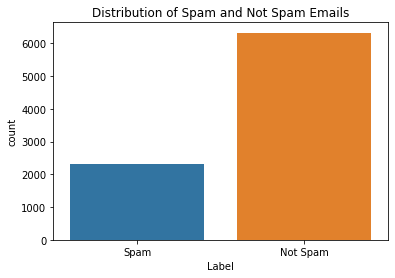

In [14]:
#Step 1: Checking the Ratio of Spam to Not Spam Emails
EDA.Label[EDA.Label==0] = "Not Spam"
EDA.Label[EDA.Label==1] = "Spam"

#Figure 1: Plot the Data Dstribution
fig1 = plt.figure()
seaborn.countplot(x='Label', data=EDA)
plt.title("Distribution of Spam and Not Spam Emails")
plt.show()

#Data Distribution: Spam (2328), Not Spam (6322)

In [120]:
#Step 2: Checking the Presence of Stopwords in Both Types of Emails

#Function for isolating each data entry based on label and saving to corpus set
def create_corpus(Label):
  corpus = []
  for x in data.loc[data['Label'] == Label, 'Body'].str.split():
    for i in x:
      corpus.append(i)

  return corpus

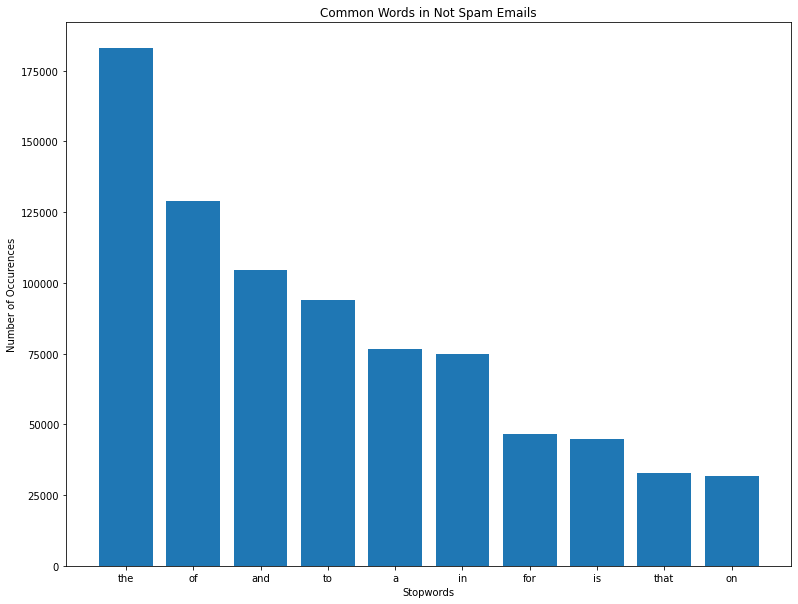

In [21]:
#List of stopwords
stop = nltk.corpus.stopwords.words("english")

#Creating a corpus of non-spam emails:
corpus = create_corpus(0)

#Saving number of stopwords occurences to dictionary
dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = zip(*top)

#Figure 2: Bar Chart of the Most Common Stopwords in 'Not Spam' Emails:
fig2 = plt.figure(figsize=(13,10))
plt.title('Common Words in Not Spam Emails')
plt.bar(x, y)
plt.xlabel("Stopwords")
plt.ylabel("Number of Occurences")
plt.show()

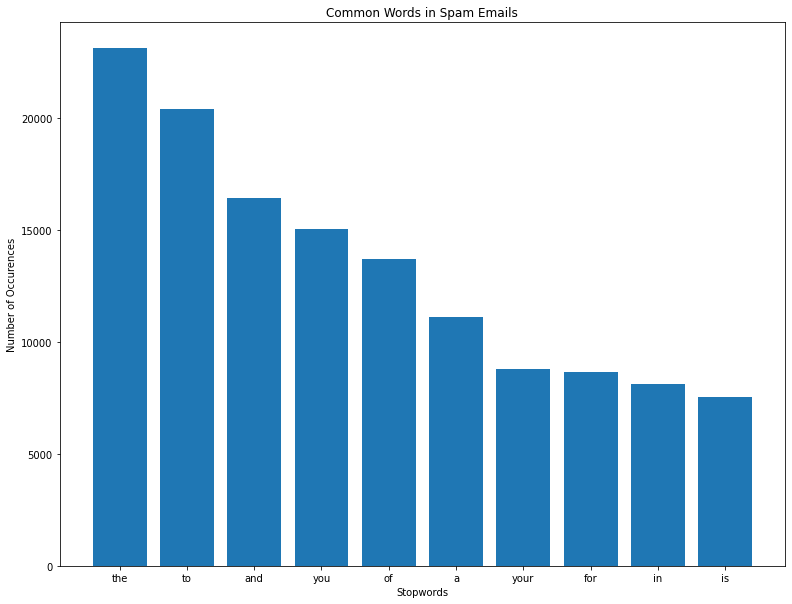

In [22]:
#Creating a corpus of spam emails:
corpus = create_corpus(1)

#Saving number of stopwords occurences to dictionary
dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1
        
top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:10]
x, y = zip(*top)

#Figure 3: Bar Chart of the Most Common Stopwords in 'Spam' Emails:
fig2 = plt.figure(figsize=(13,10))
plt.title('Common Words in Spam Emails')
plt.xlabel("Stopwords")
plt.ylabel("Number of Occurences")
plt.bar(x, y)
plt.show()

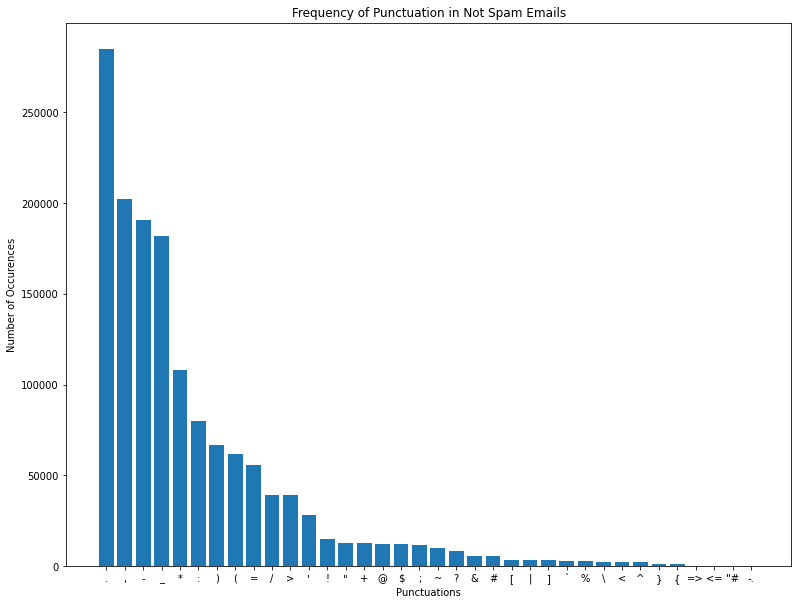

In [24]:
#Step 3: Checking for Commonalities of Punctuation in Both Types of Emails

#Creating a corpus of non-spam emails:
corpus = create_corpus(0)

#Saving number of occurences of each punctuation to dictionary
dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)
x, y = zip(*top)

#Figure 4: Bar Chart of Punctuation Freequency in Order of Most Common First for 'Not Spam' emails
fig4 = plt.figure(figsize=(13, 10))
plt.bar(x, y)
plt.title('Frequency of Punctuation in Not Spam Emails')
plt.xlabel('Punctuations')
plt.ylabel("Number of Occurences")
plt.show()

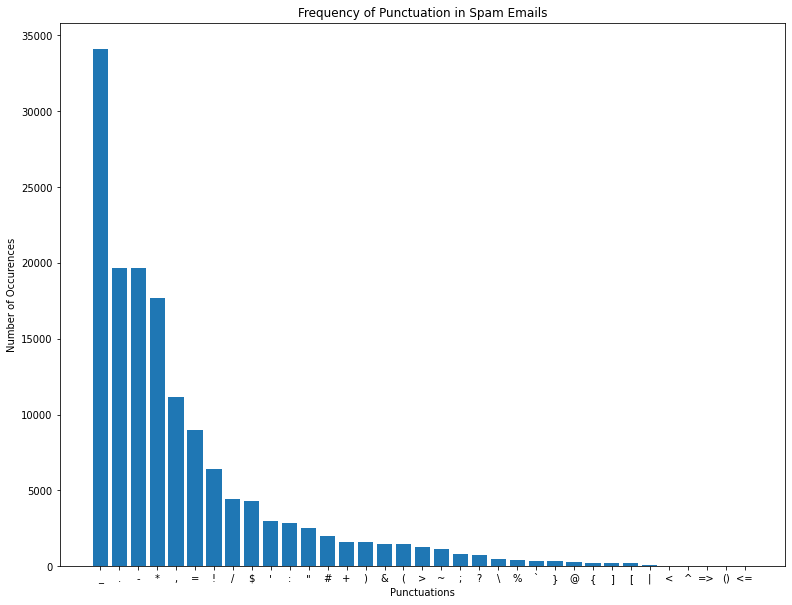

In [121]:
#Creating a corpus of spam emails:
corpus = create_corpus(1)

#Saving number of occurences of each punctuation to dictionary
dic = defaultdict(int)

special = string.punctuation
for i in corpus:
    if i in special:
        dic[i] += 1

top = sorted(dic.items(), key=lambda x: x[1], reverse=True)
x, y = zip(*top)

#Figure 5: Bar Chart of Punctuation Freequency in Order of Most Common First for 'Spam' emails

fig5 = plt.figure(figsize=(13, 10))
plt.bar(x, y)
plt.title('Frequency of Punctuation in Spam Emails')
plt.xlabel('Punctuations')
plt.ylabel("Number of Occurences")
plt.show()

3. Data Pre-Processing

In [33]:
# Step 1: Removing Links from Each Email
x = data["Body"]
x_nolinks = [re.sub(r"http\S+", "", content) for content in x]

#Example email entry with url links removed:
print(x_nolinks[0])

Subject: great part-time or summer job !
 
 * * * * * * * * * * * * * * * we have display boxes with credit applications that we need to place in the small owner-operated stores in your area . here is what you do : 1 . introduce yourself to the store owner or manager . 2 . use our 90 % effective script which tells them how this little display box will save their customers hundreds of dollars , be a drawing card for their business , and make them from $ 5 . 00 to $ 15 . 00 or more for every app sent in . 3 . find a good spot on the counter , place the box there , and say that nothing more need be done , all you need is his name and address so the company can send him the commission checks . your compensaation will be $ 10 for every box you place . by becoming a representative you could also earn a commission of $ 10 for each application that came from that store . that is of course a much more profitable plan , as it will pay you for months or years for a very small effort . call 1-888 

In [34]:
#Step 2: Remove all symbols (including punctuations)
pattern = "[^a-zA-Z0-9]"
x_nosymb = [re.sub(pattern," ", content) for content in x_nolinks]

#Step 3: Convert all characters to lower
x_lowered = [content.lower() for content in x_nosymb]

#Example of processed email:
print(x_lowered[0])

subject  great part time or summer job                                    we have display boxes with credit applications that we need to place in the small owner operated stores in your area   here is what you do   1   introduce yourself to the store owner or manager   2   use our 90   effective script which tells them how this little display box will save their customers hundreds of dollars   be a drawing card for their business   and make them from   5   00 to   15   00 or more for every app sent in   3   find a good spot on the counter   place the box there   and say that nothing more need be done   all you need is his name and address so the company can send him the commission checks   your compensaation will be   10 for every box you place   by becoming a representative you could also earn a commission of   10 for each application that came from that store   that is of course a much more profitable plan   as it will pay you for months or years for a very small effort   call 1 888 

In [35]:
#Step 4: Tokenize and split each email to a list of words
x_tokenized = [nltk.word_tokenize(content) for content in x_lowered]

#Example of tokenized email:
print(x_tokenized[0])

['subject', 'great', 'part', 'time', 'or', 'summer', 'job', 'we', 'have', 'display', 'boxes', 'with', 'credit', 'applications', 'that', 'we', 'need', 'to', 'place', 'in', 'the', 'small', 'owner', 'operated', 'stores', 'in', 'your', 'area', 'here', 'is', 'what', 'you', 'do', '1', 'introduce', 'yourself', 'to', 'the', 'store', 'owner', 'or', 'manager', '2', 'use', 'our', '90', 'effective', 'script', 'which', 'tells', 'them', 'how', 'this', 'little', 'display', 'box', 'will', 'save', 'their', 'customers', 'hundreds', 'of', 'dollars', 'be', 'a', 'drawing', 'card', 'for', 'their', 'business', 'and', 'make', 'them', 'from', '5', '00', 'to', '15', '00', 'or', 'more', 'for', 'every', 'app', 'sent', 'in', '3', 'find', 'a', 'good', 'spot', 'on', 'the', 'counter', 'place', 'the', 'box', 'there', 'and', 'say', 'that', 'nothing', 'more', 'need', 'be', 'done', 'all', 'you', 'need', 'is', 'his', 'name', 'and', 'address', 'so', 'the', 'company', 'can', 'send', 'him', 'the', 'commission', 'checks', 'yo

In [36]:
#Step 5: Lemmatize each email
lemma = WordNetLemmatizer()
x_lemmatized = [[lemma.lemmatize(word) for word in content] for content in x_tokenized]

#Example of lemmatized entry:
print(x_lemmatized[0])

['subject', 'great', 'part', 'time', 'or', 'summer', 'job', 'we', 'have', 'display', 'box', 'with', 'credit', 'application', 'that', 'we', 'need', 'to', 'place', 'in', 'the', 'small', 'owner', 'operated', 'store', 'in', 'your', 'area', 'here', 'is', 'what', 'you', 'do', '1', 'introduce', 'yourself', 'to', 'the', 'store', 'owner', 'or', 'manager', '2', 'use', 'our', '90', 'effective', 'script', 'which', 'tell', 'them', 'how', 'this', 'little', 'display', 'box', 'will', 'save', 'their', 'customer', 'hundred', 'of', 'dollar', 'be', 'a', 'drawing', 'card', 'for', 'their', 'business', 'and', 'make', 'them', 'from', '5', '00', 'to', '15', '00', 'or', 'more', 'for', 'every', 'app', 'sent', 'in', '3', 'find', 'a', 'good', 'spot', 'on', 'the', 'counter', 'place', 'the', 'box', 'there', 'and', 'say', 'that', 'nothing', 'more', 'need', 'be', 'done', 'all', 'you', 'need', 'is', 'his', 'name', 'and', 'address', 'so', 'the', 'company', 'can', 'send', 'him', 'the', 'commission', 'check', 'your', 'com

In [37]:
#Step 6: Remove Stopwords from each email
stopwords = nltk.corpus.stopwords.words("english")
x_final = [[word for word in content if word not in stopwords] for content in x_lemmatized]

#Example of fully processed email:
print(x_final[0])

['subject', 'great', 'part', 'time', 'summer', 'job', 'display', 'box', 'credit', 'application', 'need', 'place', 'small', 'owner', 'operated', 'store', 'area', '1', 'introduce', 'store', 'owner', 'manager', '2', 'use', '90', 'effective', 'script', 'tell', 'little', 'display', 'box', 'save', 'customer', 'hundred', 'dollar', 'drawing', 'card', 'business', 'make', '5', '00', '15', '00', 'every', 'app', 'sent', '3', 'find', 'good', 'spot', 'counter', 'place', 'box', 'say', 'nothing', 'need', 'done', 'need', 'name', 'address', 'company', 'send', 'commission', 'check', 'compensaation', '10', 'every', 'box', 'place', 'becoming', 'representative', 'could', 'also', 'earn', 'commission', '10', 'application', 'came', 'store', 'course', 'much', 'profitable', 'plan', 'pay', 'month', 'year', 'small', 'effort', 'call', '1', '888', '703', '5390', 'code', '3', '24', 'hour', 'receive', 'detail', 'removed', 'mailing', 'list', 'type', 'b2998', 'hotmail', 'com', 'area', 'remove', 'subject', 'area', 'new',

Additional Data Exploration (After Each Words in Each Email are Split Up)

In [31]:
#Step 1: Counting the Total Number of Unique Words or Sequences of Characters in the Dataset
number_uniquewords = len(np.unique([word for content in x_final for word in content]))
print(number_uniquewords)

92883


In [38]:
#Step 2: Checking the Most Common Words in Both Types of Email

#Preparing the Data for Word Counting:
x_wordcloud = x_final
y_wordcloud = np.asarray(data["Label"])
wordcloud_df = pd.DataFrame({'Body': x_wordcloud, 'Label': y_wordcloud})

spam_wordcloud = wordcloud_df[wordcloud_df["Label"]==1]
spam_wordcloud = spam_wordcloud.iloc[:,0]

ham_wordcloud = wordcloud_df[wordcloud_df["Label"]==0]
ham_wordcloud = ham_wordcloud.iloc[:,0]


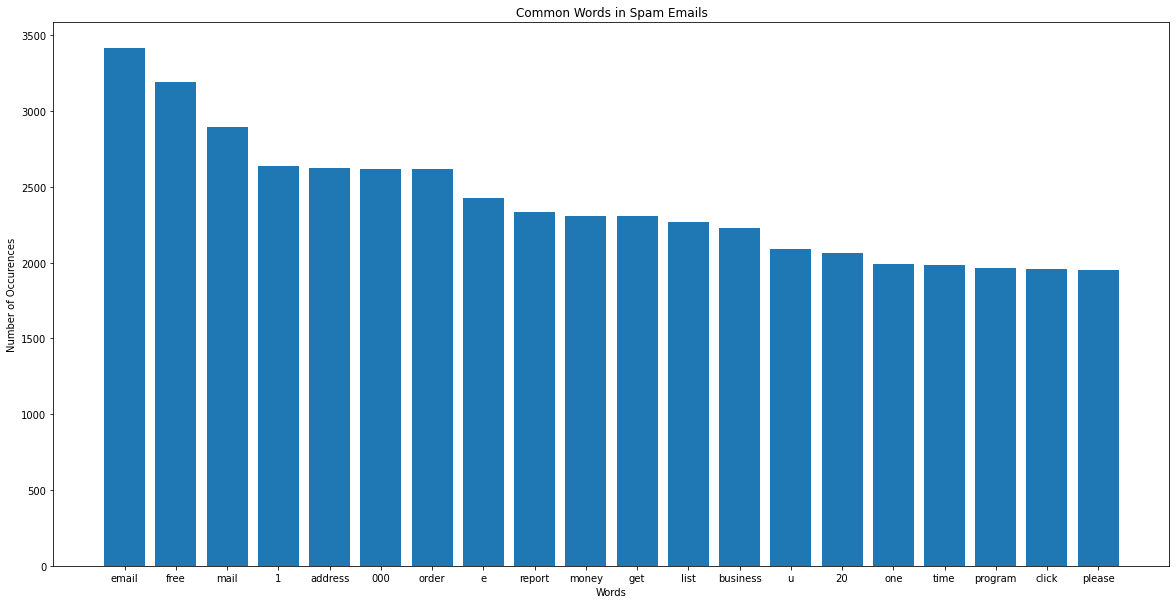

In [39]:
#Checking the Most Common Words for Spam Emails
word_dic = defaultdict(int)
for entry in spam_wordcloud:
  for word in entry:
    if word in word_dic:
      word_dic[word] += 1
    else:
      word_dic[word] = 1

top = sorted(word_dic.items(), key=lambda x: x[1], reverse=True)[:20]
x, y = zip(*top)

#Figure 6: Bar Chart of Common Words in 'Spam' Emails
fig6 = plt.figure(figsize=(20,10))
plt.title('Common Words in Spam Emails')
plt.xlabel("Words")
plt.ylabel("Number of Occurences")
plt.bar(x, y)
plt.show()

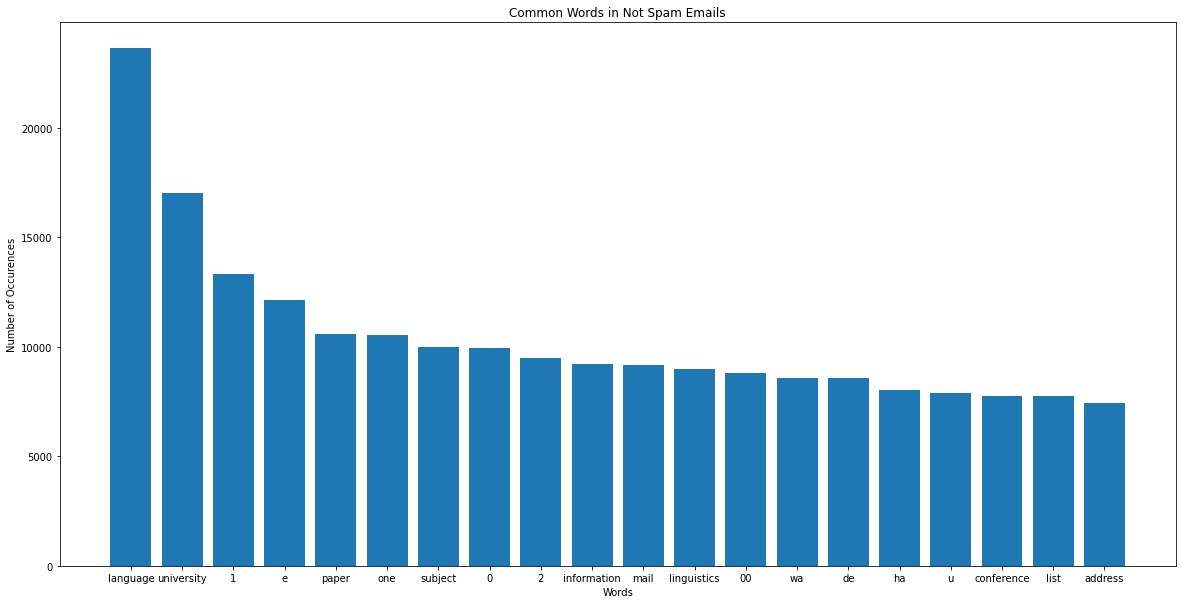

In [37]:
#Checking the Most Common Words for Not Spam Emails
word_dic = defaultdict(int)
for entry in ham_wordcloud:
  for word in entry:
    if word in word_dic:
      word_dic[word] += 1
    else:
      word_dic[word] = 1

top = sorted(word_dic.items(), key=lambda x: x[1], reverse=True)[:20]
x, y = zip(*top)

#Figure 7: Bar Chart of Common Words in 'Not Spam' Emails
fig7 = plt.figure(figsize=(20,10))
plt.title('Common Words in Not Spam Emails')
plt.xlabel("Words")
plt.ylabel("Number of Occurences")
plt.bar(x, y)
plt.show()

In [43]:
#Step 3: Creating a Wordcloud to Represent a Greater Variety of Common Words (Only for Spam Emails)

#Define Function for Creating Wordclouds:
def plot_wordcloud(text, mask=None, max_words=20000, max_font_size=100, figure_size=(17,12), 
                   title = None, title_size=40, image_color=False):
    stopwords = nltk.corpus.stopwords.words("english")
    more_stopwords = ['Subject']       #Remove the word subject since it appears very commonly as the first word of both spam and not spam emails
    stopwords = stopwords + more_stopwords

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    # random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  

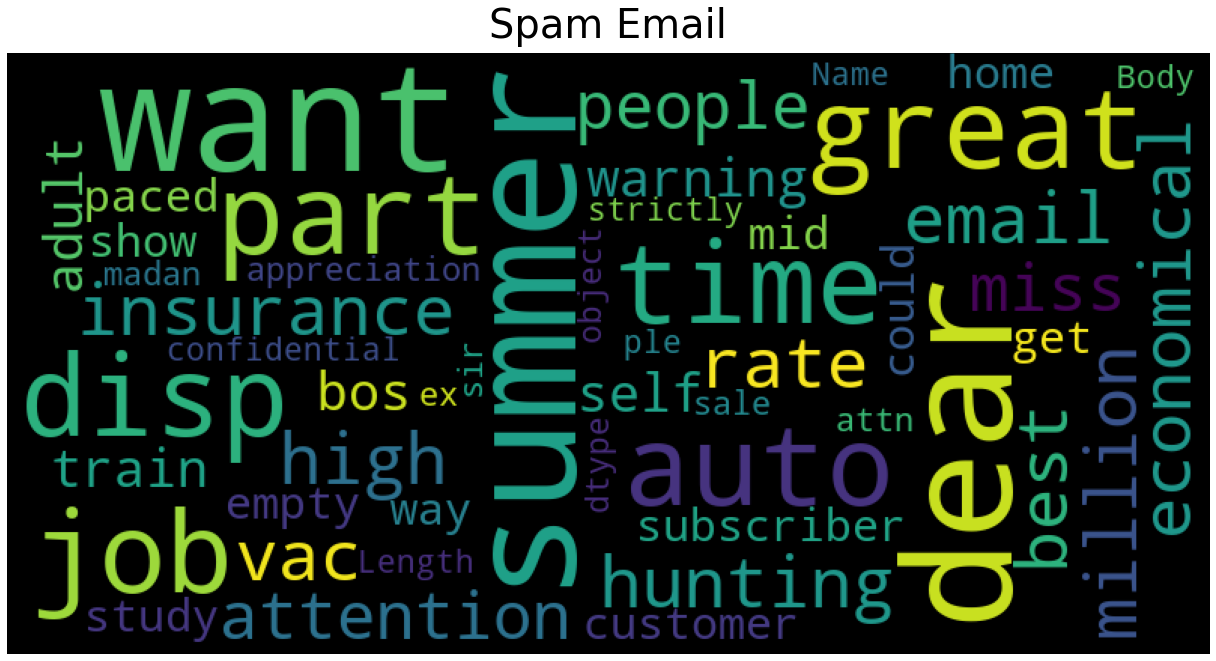

In [45]:
#Wordcloud of Common Words in Spam Emails:
plot_wordcloud(spam_wordcloud,title = 'Spam Email')

Final Data Processing and Splitting

In [40]:
#Use CountVectorizer and limit each email to be represented by 20,000 of the most common words
vectorizer = CountVectorizer(max_features=20000)
x = vectorizer.fit_transform([" ".join(content) for content in x_final]).toarray()

#Shape of Final Collection of Data
x.shape
#8,650 Emails each represented by a sequence of 20,000 numbers

(8650, 20000)

In [41]:
#Split the Data in Train and Test Dataset
y = np.asarray(data["Label"])
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2, stratify=y)

X_train.shape
#6,920 Training Emails each represented by a sequence of 20,000 numbers

(6920, 20000)

Model 1 (Datum): Dummy Classifier

In [49]:
#Creating the Model
start_time_dummy = time.time()
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
end_time_dummy = time.time()

In [50]:
#Analysis Metric 1: Time Taken
dummy_time = round(end_time_dummy-start_time_dummy,2)
print("Time Taken to Generate the Model: " + str(dummy_time))

Time Taken to Generate the Model: 0.0


In [44]:
#Predicting with the Model
y_pred_dummy = dummy_clf.predict(X_test)

In [45]:
#Analysis Metric 2: Score Report
dummy_accuracy = metrics.accuracy_score(y_test, y_pred_dummy)
print("Dummy Classifier Prediction Accuracy: " + str(dummy_accuracy))

dummy_cr = classification_report(y_test, y_pred_dummy)
print("\n" + dummy_cr)

Dummy Classifier Prediction Accuracy: 0.730635838150289

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1264
           1       0.00      0.00      0.00       466

    accuracy                           0.73      1730
   macro avg       0.37      0.50      0.42      1730
weighted avg       0.53      0.73      0.62      1730



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
#Analysis Metric 3: RMSE
y_pred_dummy_train = dummy_clf.predict(X_train)

dummy_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_dummy_train))
print("Train RMSE: %f" % (dummy_train_rmse))

dummy_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_dummy))
print("Test RMSE: %f" % (dummy_test_rmse))

Train RMSE: 0.518725
Test RMSE: 0.519003


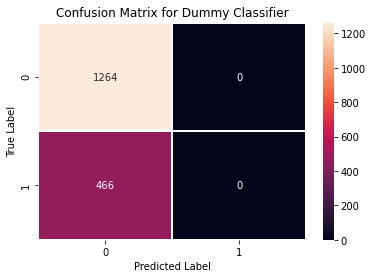

In [48]:
#Analysis Metric 4: Confusion Matrix
cf_dummy = confusion_matrix(y_test, y_pred_dummy)
seaborn.heatmap(cf_dummy, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for Dummy Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Model 2: Naive Bayes Model

In [62]:
#Creating the Model
start_time_NB = time.time()
NB = GaussianNB()
NB.fit(X_train,y_train)
end_time_NB = time.time()

In [17]:
#Analysis Metric 1: Time Taken
NB_time = round(end_time_NB-start_time_NB,2)
print("Time Taken to Generate the Model: " + str(NB_time))

Time Taken to Generate the Model: 1.9


In [63]:
#Predicting with the Model
y_pred_NB = NB.predict(X_test)

In [26]:
#Analysis Metric 2: Score Report
NB_accuracy = metrics.accuracy_score(y_test, y_pred_NB)
print("Naive Bayes Model Testing Accuracy: " + str(NB_accuracy))

NB_cr = classification_report(y_test, y_pred_NB)
print("\n" + NB_cr)

Naive Bayes Model Testing Accuracy: 0.8248554913294798

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1264
           1       0.62      0.90      0.73       466

    accuracy                           0.82      1730
   macro avg       0.79      0.85      0.80      1730
weighted avg       0.86      0.82      0.83      1730



In [21]:
#Analysis Metric 3: RMSE
y_pred_NB_train = NB.predict(X_train)

NB_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_NB_train))
print("Train RMSE: %f" % (NB_train_rmse))

NB_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_NB))
print("Test RMSE: %f" % (NB_test_rmse))

Train RMSE: 0.374204
Test RMSE: 0.418503


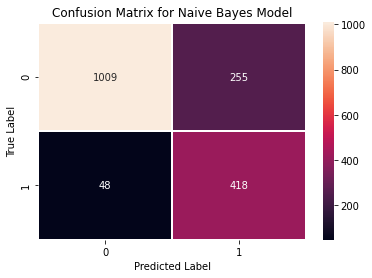

In [64]:
#Analysis Metric 4: Confusion Matrix
cf_NB = confusion_matrix(y_test, y_pred_NB)
seaborn.heatmap(cf_NB, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for Naive Bayes Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Model 3: Logistic Regression Model

In [58]:
#Creating the Model
start_time_logReg = time.time()
logReg = LogisticRegression(max_iter=900)
logReg.fit(X_train,y_train)
end_time_logReg = time.time()

In [24]:
#Analysis Metric 1: Time Taken
logReg_time = round(end_time_logReg-start_time_logReg,2)
print("Time Taken to Generate the Model: " + str(logReg_time))

Time Taken to Generate the Model: 15.07


In [59]:
#Predicting with the Model
y_pred_logReg = logReg.predict(X_test)

In [29]:
#Analysis Metric 2: Score Report
logReg_accuracy = metrics.accuracy_score(y_test, y_pred_logReg)
print("Logistic Regression Model Accuracy: " + str(logReg_accuracy))

logReg_cr = classification_report(y_test, y_pred_logReg)
print("\n" + logReg_cr)

Logistic Regression Model Accuracy: 0.9612716763005781

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1264
           1       0.90      0.97      0.93       466

    accuracy                           0.96      1730
   macro avg       0.94      0.96      0.95      1730
weighted avg       0.96      0.96      0.96      1730



In [30]:
#Analysis Metric 3: RMSE
y_pred_logReg_train = logReg.predict(X_train)

logReg_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_logReg_train))
print("Train RMSE: %f" % (logReg_train_rmse))

logReg_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_logReg))
print("Test RMSE: %f" % (logReg_test_rmse))

Train RMSE: 0.151104
Test RMSE: 0.196795


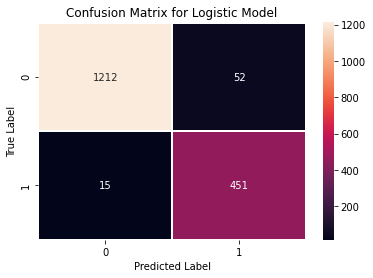

In [60]:
#Analysis Metric 4: Confusion Matrix
cf_logReg = confusion_matrix(y_test, y_pred_logReg)
seaborn.heatmap(cf_logReg, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for Logistic Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Model 4: Decision Tree

In [55]:
#Creating the Model
start_time_dt = time.time()
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)
end_time_dt = time.time()

In [34]:
#Analysis Metric 1: Time Taken
dt_time = round(end_time_dt-start_time_dt,2)
print("Time Taken to Generate the Model: " + str(dt_time))

Time Taken to Generate the Model: 18.13


In [56]:
#Predicting with the Model
y_pred_dt = dt.predict(X_test)

In [36]:
#Analysis Metric 2: Score Report
dt_accuracy = metrics.accuracy_score(y_test, y_pred_dt)
print("Decision Tree Model Accuracy: " + str(dt_accuracy))

dt_cr = classification_report(y_test, y_pred_dt)
print("\n" + dt_cr)

Decision Tree Model Accuracy: 0.9173410404624277

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1264
           1       0.80      0.93      0.86       466

    accuracy                           0.92      1730
   macro avg       0.88      0.92      0.90      1730
weighted avg       0.92      0.92      0.92      1730



In [37]:
#Analysis Metric 3: RMSE
y_pred_dt_train = dt.predict(X_train)

dt_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_dt_train))
print("Train RMSE: %f" % (dt_train_rmse))

dt_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_dt))
print("Test RMSE: %f" % (dt_test_rmse))

Train RMSE: 0.148694
Test RMSE: 0.287505


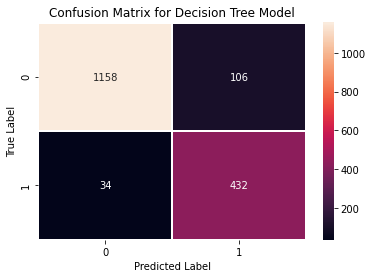

In [57]:
#Analysis Metric 4: Confusion Matrix
cf_dt = confusion_matrix(y_test, y_pred_dt)
seaborn.heatmap(cf_dt, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for Decision Tree Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Refining and Regularizing the Decision Tree by Pruning

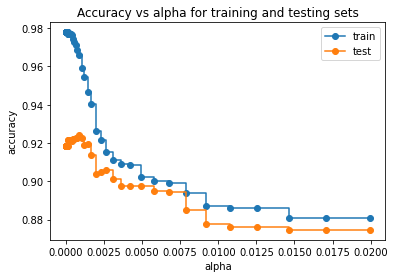

In [39]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)
alpha_space = np.logspace(-6, -1.7, num=65)
alpha_space = np.insert(alpha_space,0,0)
ccp_alphas = alpha_space

dts = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(criterion='entropy', ccp_alpha=ccp_alpha, random_state=2021)
    dt.fit(X_train, y_train)
    dts.append(dt)

train_scores = [dt.score(X_train, y_train) for dt in dts]
test_scores = [dt.score(X_test, y_test) for dt in dts]

#Figure 8: Plot of model accuracy against increasing alpha values
fig8, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

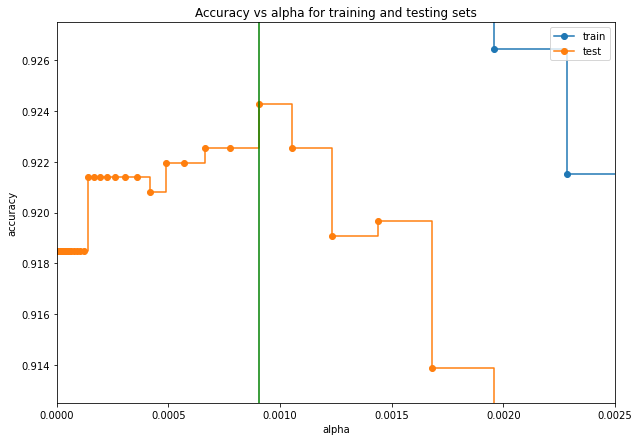

In [46]:
#Zooming in to see the peak accuracy for testing results
#Figure 9: Rescaled plot zoomed into the peak of testing accuracy
ax = plt.figure(figsize=(10,7))
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.title("Accuracy vs alpha for training and testing sets")
plt.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
plt.axvline(x=9.04169806e-04, color='green')
plt.axis([0,0.0025,0.9125,0.9275])
plt.legend()
plt.show()

#Note: Vertical Green Line Marks the Peak Testing Accuracy

In [47]:
#List of all the tested alpha values
print(ccp_alphas)

#ideal_alpha = 9.04169806e-04

[0.00000000e+00 1.00000000e-06 1.16731348e-06 1.36262076e-06
 1.59060557e-06 1.85673532e-06 2.16739217e-06 2.53002609e-06
 2.95333356e-06 3.44746607e-06 4.02427360e-06 4.69758882e-06
 5.48355874e-06 6.40103202e-06 7.47201096e-06 8.72217910e-06
 1.01815172e-05 1.18850223e-05 1.38735467e-05 1.61947780e-05
 1.89043827e-05 2.20673407e-05 2.57595042e-05 3.00694165e-05
 3.51004351e-05 4.09732110e-05 4.78285814e-05 5.58309477e-05
 6.51722178e-05 7.60764082e-05 8.88050166e-05 1.03663293e-04
 1.21007559e-04 1.41253754e-04 1.64887411e-04 1.92475298e-04
 2.24679009e-04 2.62270836e-04 3.06152281e-04 3.57375684e-04
 4.17169453e-04 4.86967525e-04 5.68443755e-04 6.63552057e-04
 7.74573260e-04 9.04169806e-04 1.05544960e-03 1.23204054e-03
 1.43817753e-03 1.67880402e-03 1.95969056e-03 2.28757320e-03
 2.67031503e-03 3.11709472e-03 3.63862668e-03 4.24741797e-03
 4.95806824e-03 5.78761988e-03 6.75596670e-03 7.88633098e-03
 9.20582045e-03 1.07460783e-02 1.25440420e-02 1.46428293e-02
 1.70927720e-02 1.995262

Model 4.1: Pruned Decision Tree

In [52]:
#Creating the Model
start_time_dt_pruned = time.time()
dt_pruned = DecisionTreeClassifier(criterion='entropy', random_state=42, ccp_alpha=9.04169806e-04)
dt_pruned.fit(X_train, y_train)
end_time_dt_pruned = time.time()

In [49]:
#Analysis Metric 1: Time Taken
dt_pruned_time = round(end_time_dt_pruned-start_time_dt_pruned,2)
print("Time Taken to Generate the Model: " + str(dt_pruned_time))

Time Taken to Generate the Model: 18.25


In [53]:
#Predicting with the Model
y_pred_dt_pruned = dt_pruned.predict(X_test)

In [51]:
#Analysis Metric 2: Score Report
dt_pruned_accuracy = metrics.accuracy_score(y_test, y_pred_dt_pruned)
print("Decision Tree Model Accuracy: " + str(dt_pruned_accuracy))

dt_pruned_cr = classification_report(y_test, y_pred_dt_pruned)
print("\n" + dt_pruned_cr)

Decision Tree Model Accuracy: 0.9242774566473988

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1264
           1       0.82      0.91      0.87       466

    accuracy                           0.92      1730
   macro avg       0.90      0.92      0.91      1730
weighted avg       0.93      0.92      0.93      1730



In [52]:
#Analysis Metric 3: RMSE
y_pred_dt_pruned_train = dt_pruned.predict(X_train)

dt_pruned_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_dt_pruned_train))
print("Train RMSE: %f" % (dt_pruned_train_rmse))

dt_pruned_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_dt_pruned))
print("Test RMSE: %f" % (dt_pruned_test_rmse))

Train RMSE: 0.185064
Test RMSE: 0.275177


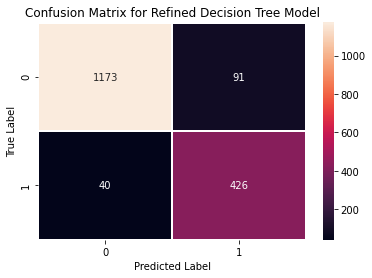

In [54]:
#Analysis Metric 4: Confusion Matrix
cf_pruned_dt = confusion_matrix(y_test, y_pred_dt_pruned)
seaborn.heatmap(cf_pruned_dt, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for Refined Decision Tree Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Model 5: Random Forest

In [49]:
#Creating the Model
start_time_rf = time.time()
rf = RandomForestClassifier(max_features="sqrt", random_state=42)
rf.fit(X_train, y_train)
end_time_rf = time.time()

In [75]:
#Analysis Metric 1: Time Taken
rf_time = round(end_time_rf-start_time_rf,2)
print("Time Taken to Generate the Model: " + str(rf_time))

Time Taken to Generate the Model: 35.63


In [50]:
#Predicting with the Model
y_pred_rf = rf.predict(X_test)

In [58]:
#Analysis Metric 2: Score Report
rf_accuracy = metrics.accuracy_score(y_test, y_pred_rf)
print("Random Forest Model Accuracy: " + str(rf_accuracy))

rf_cr = classification_report(y_test, y_pred_rf)
print("\n" + rf_cr)

Random Forest Model Accuracy: 0.9531791907514451

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1264
           1       0.89      0.95      0.92       466

    accuracy                           0.95      1730
   macro avg       0.93      0.95      0.94      1730
weighted avg       0.95      0.95      0.95      1730



In [59]:
#Analysis Metric 3: RMSE
y_pred_rf_train = rf.predict(X_train)

rf_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_rf_train))
print("Train RMSE: %f" % (rf_train_rmse))

rf_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_rf))
print("Test RMSE: %f" % (rf_test_rmse))

Train RMSE: 0.148694
Test RMSE: 0.216381


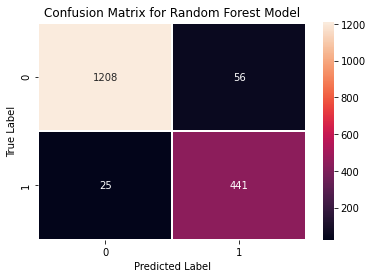

In [51]:
#Analysis Metric 4: Confusion Matrix
cf_rf = confusion_matrix(y_test, y_pred_rf)
seaborn.heatmap(cf_rf, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for Random Forest Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Refining and Regularizing Random Forest Model with Out-of-Bag Scoring

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


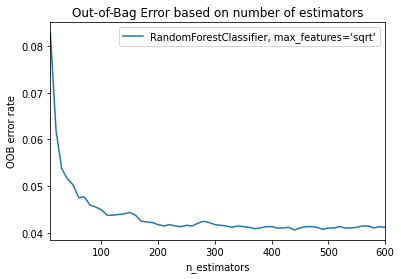

In [62]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=42)),
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 10
max_estimators = 600

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 10):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

#Figure 10: Varing Out-of-Bag Error Rate Based on Increasing Number of Trees
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.title("Out-of-Bag Error based on number of estimators")
plt.show()

Model 5.1: Refined Random Forest

In [45]:
#Creating the Model
start_time_rf_refined = time.time()
rf_refined = RandomForestClassifier(n_estimators=250, max_features="sqrt", random_state=42)
rf_refined.fit(X_train, y_train)
end_time_rf_refined = time.time()

In [76]:
#Analysis Metric 1: Time Taken
rf_refined_time = round(end_time_rf_refined-start_time_rf_refined,2)
print("Time Taken to Generate the Model: " + str(rf_refined_time))

Time Taken to Generate the Model: 99.62


In [46]:
#Predicting with the Model
y_pred_rf_refined = rf_refined.predict(X_test)

In [66]:
#Analysis Metric 2: Score Report
rf_refined_accuracy = metrics.accuracy_score(y_test, y_pred_rf_refined)
print("Random Forest Model Accuracy: " + str(rf_refined_accuracy))

rf_refined_cr = classification_report(y_test, y_pred_rf_refined)
print("\n" + rf_refined_cr)

Random Forest Model Accuracy: 0.954335260115607

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1264
           1       0.89      0.95      0.92       466

    accuracy                           0.95      1730
   macro avg       0.93      0.95      0.94      1730
weighted avg       0.96      0.95      0.95      1730



In [67]:
#Analysis Metric 3: RMSE
y_pred_rf_refined_train = rf.predict(X_train)

rf_refined_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_rf_train))
print("Train RMSE: %f" % (rf_refined_train_rmse))

rf_refined_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_rf))
print("Test RMSE: %f" % (rf_refined_test_rmse))

Train RMSE: 0.148694
Test RMSE: 0.216381


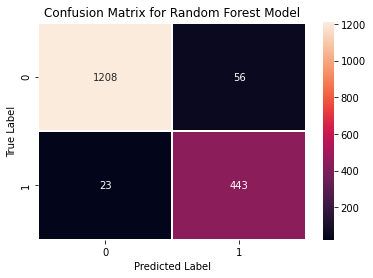

In [48]:
#Analysis Metric 4: Confusion Matrix
cf_rf_refined = confusion_matrix(y_test, y_pred_rf_refined)
seaborn.heatmap(cf_rf_refined, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for Random Forest Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Model 6: XGBOOST

In [36]:
#Creating the Model
start_time_xgb = time.time()
xgb_model = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 10, alpha = 10, n_estimators = 159)
xgb_model.fit(X_train, y_train)
end_time_xgb = time.time()

In [95]:
#Analysis Metric 1: Time Taken
xgb_time = round(end_time_xgb-start_time_xgb,2)
print("Time Taken to Generate the Model: " + str(xgb_time))

Time Taken to Generate the Model: 505.92


In [43]:
#Predicting with the Model
y_pred_xgb = xgb_model.predict(X_test)

In [97]:
#Analysis Metric 2: Score Report
xgb_accuracy = metrics.accuracy_score(y_test, y_pred_xgb)
print("XGBOOST Model Accuracy: " + str(xgb_accuracy))

xgb_cr = classification_report(y_test, y_pred_xgb)
print("\n" + xgb_cr)

XGBOOST Model Accuracy: 0.9606936416184971

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1264
           1       0.89      0.97      0.93       466

    accuracy                           0.96      1730
   macro avg       0.94      0.96      0.95      1730
weighted avg       0.96      0.96      0.96      1730



In [98]:
#Analysis Metric 3: RMSE
y_pred_xgb_train = xgb_model.predict(X_train)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_xgb_train))
print("Train RMSE: %f" % (xgb_train_rmse))

xgb_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_xgb))
print("Test RMSE: %f" % (xgb_test_rmse))

Train RMSE: 0.158114
Test RMSE: 0.198258


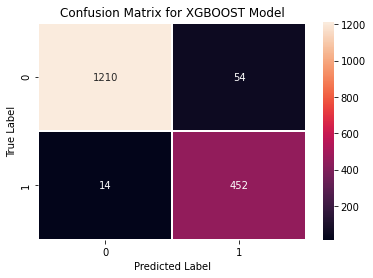

In [44]:
#Analysis Metric 4: Confusion Matrix
cf_xgb = confusion_matrix(y_test, y_pred_xgb)
seaborn.heatmap(cf_xgb, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for XGBOOST Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Veryfing the Model via K-fold Cross Validation

In [79]:
#Preparing the data for Cross Validation
data_dmatrix = xgb.DMatrix(data=x, label=y)

#Setting Up the Parameters to Test for the XGBOOST Model
params = {"objective":"reg:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1, 'max_depth': 10, 'alpha': 10}

In [80]:
#Cross Validation
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3, num_boost_round=300, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42)


In [81]:
cv_results

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0           0.472878        0.000145        0.473841       0.000434
1           0.449138        0.000410        0.451172       0.001518
2           0.428645        0.001650        0.431626       0.003939
3           0.406264        0.001007        0.409862       0.002593
4           0.387947        0.000818        0.392534       0.003052
..               ...             ...             ...            ...
154         0.165147        0.003819        0.189324       0.007098
155         0.165147        0.003819        0.189324       0.007098
156         0.165147        0.003819        0.189324       0.007098
157         0.165151        0.003815        0.189344       0.007109
158         0.165067        0.003915        0.189265       0.007063

[159 rows x 4 columns]

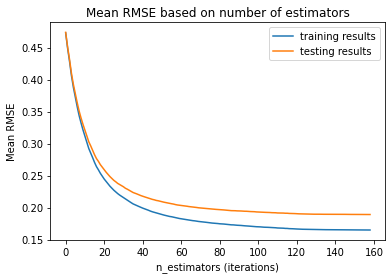

In [82]:
#Figure 11: Varying Train and Testing Mean RMSE on Increasing Model Iterations
fig11 = plt.figure()
plt.plot(cv_results.index, cv_results["train-rmse-mean"], label="training results")
plt.plot(cv_results.index, cv_results["test-rmse-mean"], label="testing results")
plt.ylabel('Mean RMSE')
plt.xlabel('n_estimators (iterations)')
plt.title('Mean RMSE based on number of estimators')
plt.legend()
plt.show()

Model 7: Basic Sequential Neural Networking Model (Using  CountVectorized Data)

In [14]:
#Creating the Model
start_time_basic_nn = time.time()

model = Sequential()
model.add(Dense(units=20000,activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(units=10000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=2500,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, 0.0001)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(x=X_train,y=y_train,epochs=11,validation_data=(X_test, y_test), verbose=1,callbacks=[early_stop])
end_time_basic_nn = time.time()


Epoch 1/11
217/217 [==============================] - 511s 2s/step - loss: 0.4250 - accuracy: 0.8521 - val_loss: 0.1052 - val_accuracy: 0.9618
Epoch 2/11
217/217 [==============================] - 501s 2s/step - loss: 0.1050 - accuracy: 0.9698 - val_loss: 0.1653 - val_accuracy: 0.9480
Epoch 3/11
217/217 [==============================] - 509s 2s/step - loss: 0.0802 - accuracy: 0.9785 - val_loss: 0.1899 - val_accuracy: 0.9555
Epoch 4/11
217/217 [==============================] - 509s 2s/step - loss: 0.0563 - accuracy: 0.9702 - val_loss: 0.3542 - val_accuracy: 0.9630
Epoch 5/11
217/217 [==============================] - 503s 2s/step - loss: 0.0754 - accuracy: 0.9751 - val_loss: 0.2287 - val_accuracy: 0.9618
Epoch 6/11
217/217 [==============================] - 515s 2s/step - loss: 0.0426 - accuracy: 0.9756 - val_loss: 0.2319 - val_accuracy: 0.9601
Epoch 7/11
217/217 [==============================] - 503s 2s/step - loss: 0.0376 - accuracy: 0.9803 - val_loss: 0.2119 - val_accuracy: 0.9613

In [15]:
#Summary of the Model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20000)             400020000 
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10000)             200010000 
_________________________________________________________________
dropout_1 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2500)              25002500  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              2

In [16]:
#Analysis Metric 1: Time Taken
basic_nn_time = round(end_time_basic_nn-start_time_basic_nn,2)
print("Time Taken to Generate the Model: " + str(basic_nn_time))

Time Taken to Generate the Model: 5602.89


In [17]:
#Predicting with the Model
y_pred_basic_nn = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [18]:
#Analysis Metric 2: Score Report
basic_nn_accuracy = metrics.accuracy_score(y_test, y_pred_basic_nn)
print("Sequential Neural Network Model Accuracy: " + str(basic_nn_accuracy))

basic_nn_cr = classification_report(y_test, y_pred_basic_nn)
print("\n" + basic_nn_cr)

Sequential Neural Network Model Accuracy: 0.9618497109826589

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1264
           1       0.89      0.98      0.93       466

    accuracy                           0.96      1730
   macro avg       0.94      0.97      0.95      1730
weighted avg       0.96      0.96      0.96      1730



In [19]:
#Analysis Metric 3: RMSE
y_pred_basic_nn_train = model.predict_classes(X_train)
basic_nn_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_basic_nn_train))
print("Train RMSE: %f" % (basic_nn_train_rmse))

basic_nn_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_basic_nn))
print("Test RMSE: %f" % (basic_nn_test_rmse))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Train RMSE: 0.148694
Test RMSE: 0.195321


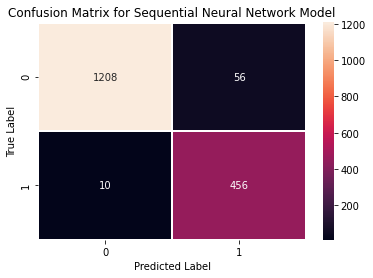

In [33]:
#Analysis Metric 4: Confusion Matrix
cf_basic_nn = confusion_matrix(y_test, y_pred_basic_nn)
seaborn.heatmap(cf_basic_nn, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for Sequential Neural Network Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [24]:
#Defining a function for plotting Accuracy and Loss over iterations

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

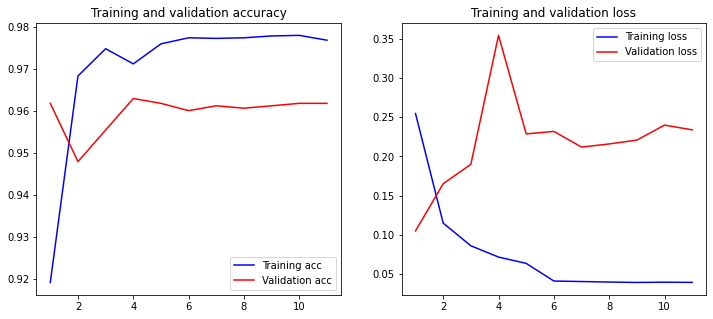

In [41]:
#Figure 12: Plot of Accuracy and Loss over model iterations (For Basic Sequential Neural Network)
plot_history(history)

Model 8: Recurrent Neural Network (LSTM)

In [65]:
#Data Preparation
#Step 1: Recall the processed data before being vectorized
x_final

[['subject',
  'great',
  'part',
  'time',
  'summer',
  'job',
  'display',
  'box',
  'credit',
  'application',
  'need',
  'place',
  'small',
  'owner',
  'operated',
  'store',
  'area',
  '1',
  'introduce',
  'store',
  'owner',
  'manager',
  '2',
  'use',
  '90',
  'effective',
  'script',
  'tell',
  'little',
  'display',
  'box',
  'save',
  'customer',
  'hundred',
  'dollar',
  'drawing',
  'card',
  'business',
  'make',
  '5',
  '00',
  '15',
  '00',
  'every',
  'app',
  'sent',
  '3',
  'find',
  'good',
  'spot',
  'counter',
  'place',
  'box',
  'say',
  'nothing',
  'need',
  'done',
  'need',
  'name',
  'address',
  'company',
  'send',
  'commission',
  'check',
  'compensaation',
  '10',
  'every',
  'box',
  'place',
  'becoming',
  'representative',
  'could',
  'also',
  'earn',
  'commission',
  '10',
  'application',
  'came',
  'store',
  'course',
  'much',
  'profitable',
  'plan',
  'pay',
  'month',
  'year',
  'small',
  'effort',
  'call',
  '1',

In [12]:
#Defining a function to join all the words back into one entry
def perform_preprocess(data):
    corpus = []
    for entry in data:
        entry = ' '.join(entry)
        corpus.append(entry)
    return corpus

In [13]:
#Step 2: Apply the function to the data and save to corpus
corpus = perform_preprocess(x_final)

#Example output:
corpus[0]

'subject great part time summer job display box credit application need place small owner operated store area 1 introduce store owner manager 2 use 90 effective script tell little display box save customer hundred dollar drawing card business make 5 00 15 00 every app sent 3 find good spot counter place box say nothing need done need name address company send commission check compensaation 10 every box place becoming representative could also earn commission 10 application came store course much profitable plan pay month year small effort call 1 888 703 5390 code 3 24 hour receive detail removed mailing list type b2998 hotmail com area remove subject area new e mail send'

In [14]:
#Step 3: Convert each entry in the corpus into one hot vectors
vocab_size = 20000
one_hot = [one_hot(word,vocab_size) for word in corpus]

In [15]:
#Step 4: Add pre-padding to each one hot vector to ensure equal length
sent_length = 8700
embedd_docs = pad_sequences(one_hot,padding='pre',maxlen=sent_length)

#Example Output:
embedd_docs[0]

array([    0,     0,     0, ..., 16062,  5105, 10834], dtype=int32)

In [16]:
#Step 5: Split the data for train and test
x_completed = np.array(embedd_docs)
y = np.asarray(data["Label"])
X_train, X_test, y_train, y_test = train_test_split(x_completed, y, random_state=42, test_size=0.2, stratify=y)

In [17]:
#Creating the Model
start_time_lstm_nn = time.time()
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=15, batch_size=64)
end_time_lstm_nn = time.time()


Epoch 1/15
109/109 [==============================] - 1747s 16s/step - loss: 0.4995 - accuracy: 0.7817 - val_loss: 0.1185 - val_accuracy: 0.9514
Epoch 2/15
109/109 [==============================] - 1781s 16s/step - loss: 0.1110 - accuracy: 0.9520 - val_loss: 0.1017 - val_accuracy: 0.9561
Epoch 3/15
109/109 [==============================] - 1746s 16s/step - loss: 0.0632 - accuracy: 0.9688 - val_loss: 0.1213 - val_accuracy: 0.9526
Epoch 4/15
109/109 [==============================] - 1757s 16s/step - loss: 0.0584 - accuracy: 0.9754 - val_loss: 0.1200 - val_accuracy: 0.9358
Epoch 5/15
109/109 [==============================] - 1765s 16s/step - loss: 0.0521 - accuracy: 0.9721 - val_loss: 0.1000 - val_accuracy: 0.9613
Epoch 6/15
109/109 [==============================] - 1749s 16s/step - loss: 0.0428 - accuracy: 0.9784 - val_loss: 0.1115 - val_accuracy: 0.9543
Epoch 7/15
109/109 [==============================] - 1764s 16s/step - loss: 0.0491 - accuracy: 0.9750 - val_loss: 0.1220 - val_ac

In [26]:
#Summary of the Model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8700, 40)          800000    
_________________________________________________________________
dropout (Dropout)            (None, 8700, 40)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 856,501
Trainable params: 856,501
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
#Analysis Metric 1: Time Taken
lstm_nn_time = round(end_time_lstm_nn-start_time_lstm_nn,2)
print("Time Taken to Generate the Model: " + str(lstm_nn_time))

Time Taken to Generate the Model: 26309.92


In [19]:
#Predicting with the Model
y_pred_lstm_nn = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [20]:
#Analysis Metric 2: Score Report
lstm_nn_accuracy = metrics.accuracy_score(y_test, y_pred_lstm_nn)
print("LSTM Neural Network Model Accuracy: " + str(lstm_nn_accuracy))

lstm_nn_cr = classification_report(y_test, y_pred_lstm_nn)
print("\n" + lstm_nn_cr)

LSTM Neural Network Model Accuracy: 0.9618497109826589

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1264
           1       0.90      0.97      0.93       466

    accuracy                           0.96      1730
   macro avg       0.94      0.96      0.95      1730
weighted avg       0.96      0.96      0.96      1730



In [22]:
#Analysis Metric 3: RMSE
y_pred_lstm_nn_train = model.predict_classes(X_train)
lstm_nn_train_rmse = np.sqrt(mean_squared_error(y_train,y_pred_lstm_nn_train))
print("Train RMSE: %f" % (lstm_nn_train_rmse))

lstm_nn_test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_lstm_nn))
print("Test RMSE: %f" % (lstm_nn_test_rmse))

Train RMSE: 0.148694
Test RMSE: 0.195321


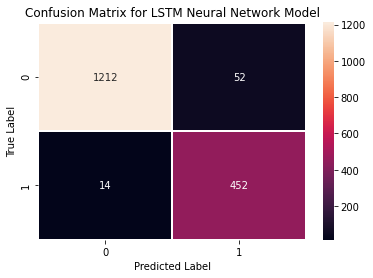

In [23]:
#Analysis Metric 4: Confusion Matrix
cf_lstm_nn = confusion_matrix(y_test, y_pred_lstm_nn)
seaborn.heatmap(cf_lstm_nn, annot=True, fmt=".0f", linewidths=1.5)
plt.title("Confusion Matrix for LSTM Neural Network Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

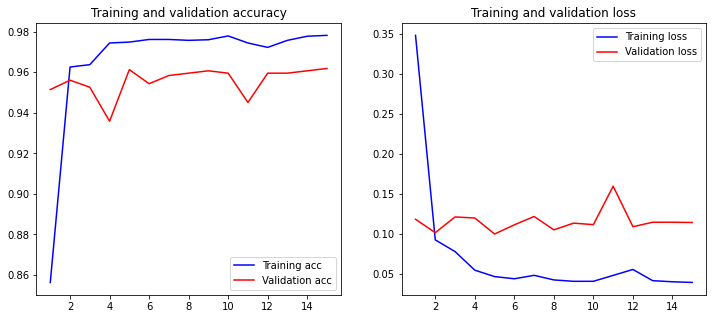

In [25]:
#Figure 13: Plot of Accuracy and Loss over model iterations (For LSTM Neural Network)
plot_history(history)

Summary of Results

In [1]:
#@title Copy of Results
dummy_time = 0.00
dummy_accuracy = round(0.730635838150289, 4)
dummy_test_rmse = round(0.519003, 4)

NB_time = 1.90
NB_accuracy = round(0.8248554913294798, 4)
NB_test_rmse = round(0.418503, 4)

logReg_time = 15.07
logReg_accuracy = round(0.9612716763005781, 4)
logReg_test_rmse = round(0.196795, 4)

dt_pruned_time = 18.25
dt_pruned_accuracy = round(0.9242774566473988, 4)
dt_pruned_test_rmse = round(0.275177, 4)

rf_refined_time = 99.62
rf_refined_accuracy = round(0.954335260115607, 4)
rf_refined_test_rmse = round(0.216381, 4)

xgb_time = 505.92
xgb_accuracy = round(0.9606936416184971, 4)
xgb_test_rmse = round(0.198258, 4)

basic_nn_time = 5602.89
basic_nn_accuracy = round(0.9618497109826589, 4)
basic_nn_test_rmse = round(0.195321, 4)

lstm_nn_time = 26309.92
lstm_nn_accuracy = round(0.9618497109826589, 4)
lstm_nn_test_rmse = round(0.195321, 4)

dummy_precision = 0.00
NB_precision = 0.62
logReg_precision = 0.90
dt_pruned_precision = 0.82
rf_refined_precision = 0.89
xgb_precision = 0.89
basic_nn_precision = 0.89
lstm_nn_precision = 0.90

In [2]:
time_results = [dummy_time, NB_time, logReg_time, dt_pruned_time, rf_refined_time, xgb_time, basic_nn_time, lstm_nn_time]
accuracy_results = [dummy_accuracy, NB_accuracy, logReg_accuracy, dt_pruned_accuracy, rf_refined_accuracy, xgb_accuracy, basic_nn_accuracy, lstm_nn_accuracy]
test_rmse = [dummy_test_rmse, NB_test_rmse, logReg_test_rmse, dt_pruned_test_rmse, rf_refined_test_rmse, xgb_test_rmse, basic_nn_test_rmse, lstm_nn_test_rmse]
precision_results = [dummy_precision, NB_precision, logReg_precision, dt_pruned_precision, rf_refined_precision, xgb_precision, basic_nn_precision, lstm_nn_precision]

In [80]:
time_results

[0.0, 1.9, 15.07, 18.25, 99.62, 505.92, 5602.89, 26309.92]

In [55]:
accuracy_results

[0.7306, 0.8249, 0.9613, 0.9243, 0.9543, 0.9607, 0.9618, 0.9618]

In [61]:
test_rmse

[0.519, 0.4185, 0.1968, 0.2752, 0.2164, 0.1983, 0.1953, 0.1953]

In [71]:
precision_results

[0.0, 0.62, 0.9, 0.82, 0.89, 0.89, 0.89, 0.9]

In [5]:
results_df = pd.DataFrame({"Time(s)": time_results, "Accuracy": accuracy_results, "Test-RMSE": test_rmse, "PrecisionScore": precision_results}, index= ["Dummy Classifier", "Naive Bayes", " Logistic Regression", "Decision Tree", "Random Forest", "XGBOOST", "Basic Sequential Neural Network", "Recurrent Neural Network (LSTM)"])

In [6]:
results_df

Time(s)  Accuracy  Test-RMSE  PrecisionScore
Dummy Classifier                     0.00    0.7306     0.5190            0.00
Naive Bayes                          1.90    0.8249     0.4185            0.62
 Logistic Regression                15.07    0.9613     0.1968            0.90
Decision Tree                       18.25    0.9243     0.2752            0.82
Random Forest                       99.62    0.9543     0.2164            0.89
XGBOOST                            505.92    0.9607     0.1983            0.89
Basic Sequential Neural Network   5602.89    0.9618     0.1953            0.89
Recurrent Neural Network (LSTM)  26309.92    0.9618     0.1953            0.90